In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os



import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox



from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# This one is only available in the development verison of statsmodels
# Run:
#    pip install git+https://github.com/statsmodels/statsmodels.git
# to install the development version.
from statsmodels.tsa.statespace.sarimax import SARIMAX


# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score

from sklearn.linear_model import LinearRegression


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor


from scipy import signal
from scipy import stats

sys.path.append("..")
from eda_utilities import print_eda_stats
from data_pipeline import dockless_data_pipeline
from data_pipeline import weather_data_pipeline
from data_pipeline import find_top_group_by_column_list
from data_pipeline import prepare_cell_data
from data_pipeline import remove_invalid_trips

In [2]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    score = model.score(test_features, test_labels)
    print('Model Performance')
    print("Mean Square Error:", mean_squared_error(test_labels, predictions))
    print("Mean Absoulute Error:", mean_absolute_error(test_labels, predictions))
    print("Score:", score)
    return score

In [3]:
dockless_data = pd.read_csv("https://s3.amazonaws.com/sameera-bucket-1/dockless_mobility/raw_data/Austin_Dockless_Vehicle_Trips.csv")
dockless_vehicles_columns = dockless_data.columns
print_eda_stats(dockless_data, dockless_vehicles_columns, "Austin Dockless Mobility Data")
# Call the dockless_data_pipeline()
dockless_data = dockless_data_pipeline(dockless_data)
dockless_vehicles_columns = dockless_data.columns
print_eda_stats(dockless_data, dockless_vehicles_columns, "Austin Dockless Mobility Data")
dockless_data = remove_invalid_trips(dockless_data)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


+--------------------------+---------+-------------+---------------+--------------+-------------------+
|       Column Name        |  dtype  | Total_Count | Unique_Values | df_totalrows | Null Value counts |
+--------------------------+---------+-------------+---------------+--------------+-------------------+
|            ID            |  object |   2746505   |    2746505    |   2746505    |         0         |
|        Device ID         |  object |   2746505   |     26999     |   2746505    |         0         |
|       Vehicle Type       |  object |   2746504   |       3       |   2746505    |         1         |
|      Trip Duration       | float64 |   2746504   |     10521     |   2746505    |         1         |
|      Trip Distance       | float64 |   2746504   |     16125     |   2746505    |         1         |
|        Start Time        |  object |   2746504   |     25694     |   2746505    |         1         |
|         End Time         |  object |   2746504   |     25768  

In [4]:
#Read the weather data from S3 bucket
weather_data = pd.read_csv("https://s3.amazonaws.com/sameera-bucket-1/dockless_mobility/raw_data/Austin_Bergstom_Airport_Weather.csv")
weather_columns = weather_data.columns
print_eda_stats(weather_data, weather_columns, "Austin Weather Data")
weather_data = weather_data_pipeline(weather_data)
weather_columns = weather_data.columns
print_eda_stats(weather_data, weather_columns, "Austin Weather Data")


+-----------------+---------+-------------+---------------+--------------+-------------------+
|   Column Name   |  dtype  | Total_Count | Unique_Values | df_totalrows | Null Value counts |
+-----------------+---------+-------------+---------------+--------------+-------------------+
|     STATION     |  object |     436     |       1       |     436      |         0         |
|       NAME      |  object |     436     |       1       |     436      |         0         |
|     LATITUDE    | float64 |     436     |       1       |     436      |         0         |
|    LONGITUDE    | float64 |     436     |       1       |     436      |         0         |
|    ELEVATION    | float64 |     436     |       1       |     436      |         0         |
|       DATE      |  object |     436     |      436      |     436      |         0         |
|       AWND      | float64 |     435     |       73      |     436      |         1         |
| AWND_ATTRIBUTES |  object |     435     |       

In [5]:
# Retrieve the top 10 origin cell IDs
top_10_origin_cell = find_top_group_by_column_list(dockless_data, 'Origin Cell ID', 'Trip Duration', 'count', n=10)

In [6]:
top_10_origin_cell

['014706',
 '014707',
 '014864',
 '014705',
 '015186',
 '015019',
 '014865',
 '014391',
 '014863',
 '015029']

In [7]:
data_cell_data_hour = prepare_cell_data(dockless_data, weather_data, "014391")

In [8]:
# Create the test train split the same way as the univariate time series so this is the same as ARIMA series
size = int(len(data_cell_data_hour) * 0.66)
train, test = data_cell_data_hour[0:size], data_cell_data_hour[size:len(data_cell_data_hour)]

y_train = train.pop('Trip Counts').values
X_train = train.values
y_test = test.pop('Trip Counts').values
X_test = test.values

best_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=12, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

best_rf.fit(X_train, y_train)
best_random_forest_accuracy = evaluate(best_rf, X_test, y_test)

best_rf_predictions = best_rf.predict(X_test)

Model Performance
Mean Square Error: 18.45461480165581
Mean Absoulute Error: 2.7454699528693496
Score: 0.6052128357490097


In [9]:
for i,j in  zip(train.columns.tolist(), best_rf.feature_importances_):
    print(i, ":", j)

MONTH : 0.025917366162700444
YEAR : 0.0
HOUR : 0.4661497959822509
DAY : 0.025828034571567987
WEEK : 0.02843670248852797
DAY_OF_WEEK : 0.029392564376332874
WEEKEND : 0.005802986813635429
WEEKDAY : 0.005946231277194778
HOUR_LABEL : 0.28973708848501256
AVG_DAILY_WIND_SPEED : 0.023674833072725096
PRECIPITATION : 0.02490419933251491
SNOW : 0.0
AVG_TEMPERATURE : 0.022948184087126008
MAX_TEMPERATURE : 0.031337353565896946
MIN_TEMPERATURE : 0.019924659784514496


In [10]:
size = int(len(data_cell_data_hour) * 0.66)
train_1, test_1 = data_cell_data_hour[0:size], data_cell_data_hour[size:len(data_cell_data_hour)]
test_results = test_1.drop(['MONTH', 'YEAR', 'HOUR', 'DAY', 'WEEK', 'DAY_OF_WEEK',
       'WEEKEND', 'WEEKDAY',
       'AVG_DAILY_WIND_SPEED', 'PRECIPITATION', 'SNOW', 'AVG_TEMPERATURE', 'HOUR_LABEL',
       'MAX_TEMPERATURE', 'MIN_TEMPERATURE'], axis=1)
test_results.rename(columns=dict(zip(["Trip Counts"], ["Actual"])), inplace=True)
rf_list = best_rf_predictions.tolist()
test_results['rf_predictions'] = rf_list

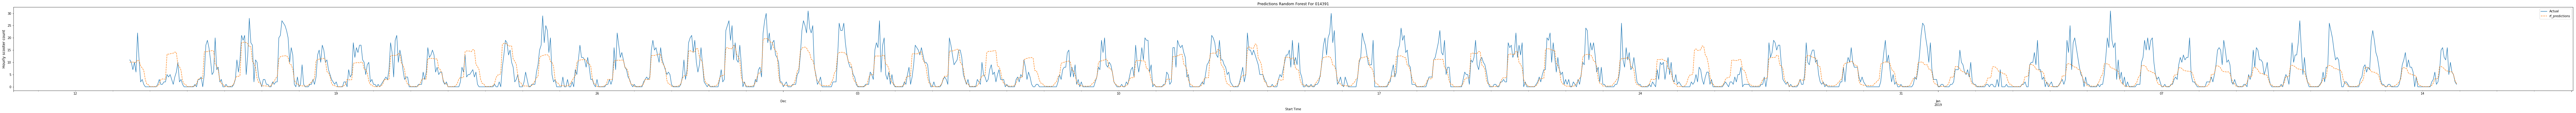

In [11]:
test_results.plot(style=['-', '--', ':'],figsize=(150, 5))
plt.title('Predictions Random Forest For 014391')
plt.ylabel('Hourly scooter count', fontsize=12)
plt.savefig('../../output/Random_Forest_Predictions_Commuter_Hours_014391_2_with_greater_than_01miles.png')

In [15]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3, 5, 7, 10, 13, 14],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)


# Fit the grid search to the data
grid_search.fit(X_train, y_train)
#print("Grid Search Best Parameters:" grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)


Fitting 3 folds for each of 1008 candidates, totalling 3024 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   3.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.1s
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   4.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2

[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   4.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_le

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   29.3s


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_

[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.4s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5,

[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.4s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, 

[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   4.5s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_

[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   4.7s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_s

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min


[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.5s
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=7, 

[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.4s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.9s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=7

[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.1s
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=

[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.4s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   6.8s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_feat

[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   7.1s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   6.9s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_feat

[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   6.7s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   6.9s
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   6.7s
[CV] bootstrap=True, max_depth=80, max_featu

[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.6s
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   8.1s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_sa

[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   2.4s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   8.7s
[CV] bootstrap=True, max_depth=80, max_featu

[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.3s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.2s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.2s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_fea

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.0min


[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   7.7s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   7.9s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   7.7s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_feat

[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   8.3s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   8.6s
[CV] bootstrap=True, max_depth=80, max_featu

[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   8.8s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_feat

[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.3s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.3s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_feat

[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   3.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   7.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   3.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=

[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2

[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   3.2s
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=

[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=3,

[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   3.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.8s
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3,

[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   4.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   4.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3,

[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.5s
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   3.8s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=5, 

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.7min


[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   4.6s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=5

[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_

[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   4.9s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=5

[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   6.6s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   6.2s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=7,

[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   5.6s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   5.5s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=7, 

[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   5.2s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   5.0s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   5.0s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=7, 

[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   7.0s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   7.2s
[CV] bootstrap=True, max_depth=90, max_featu

[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   2.1s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   6.8s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_feat

[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.0s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.9s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_feat

[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.3s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.2s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.3s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_fe

[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.7s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   2.4s
[CV] bootstrap=True, max_depth=90, max_fe

[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   7.5s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   2.0s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.9s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_f

[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   7.3s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.9s
[CV] bootstrap=True, max_depth=90, max_feat

[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  7.3min


[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   2.7s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   2.5s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   2.4s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_feature

[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.7s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   2.7s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   2.5s
[CV] bootstrap=True, max_depth=90, max_features=

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   7.9s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_featur

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   4.3s
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   4.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   4.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_featu

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   3.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   3.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_feature

[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   4.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   4.1s
[CV] bootstrap=True, max_depth=100, max_features

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   4.2s
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   4.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_feature

[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   4.5s
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=100, max_features=

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.6s
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=1

[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_fe

[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_

[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   4.8s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_fea

[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   6.0s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   6.2s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_fea

[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   5.7s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   5.6s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   5.4s
[CV] bootstrap=True, max_depth=100, max_feat

[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   5.1s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_fea

[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.9s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=100, 

[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  9.8min


[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   6.2s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.9s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.7s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=10

[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.8s
[CV] bootstrap=True, max_depth=100

[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   6.0s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100

[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   7.4s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   7.5s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.5s
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV] bootstrap=True, max_depth=100, 

[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   7.4s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   7.3s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100,

[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   7.0s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=100, 

[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.4s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.3s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100,

[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   2.3s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   2.3s
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   2.2s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.7s
[CV]  bootstrap=True, max_depth=10

[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.2s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.2s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=1

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   7.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   7.2s
[CV] bootstrap=True, max_depth=110, ma

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   3.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_f

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   3.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_fea

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   3.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_fe

[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   3.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_fea

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_featu

[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   3.8s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   4.0s
[CV]  bootstrap=True, max_depth=110, max_fea

[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_feature

[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=5

[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 12.6min


[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   4.4s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   4.4s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   4.3s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_fea

[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   5.5s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   5.6s
[CV] bootstrap=True, max_depth=110, max_feat

[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   5.3s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_fea

[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_fea

[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.0s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.1s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.0s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=11

[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   2.5s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   2.3s
[CV] bootstrap=True, max_depth=11

[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   7.0s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=1

[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.7s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.7s
[CV] bootstrap=True, max_depth=110, 

[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   8.6s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   8.3s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=11

[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   8.4s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   8.3s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=110

[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   2.5s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   7.7s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   7.9s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110

[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   2.7s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=110, ma

[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   2.3s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   2.3s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   2.1s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max

[Parallel(n_jobs=-1)]: Done 3024 out of 3024 | elapsed: 15.4min finished


Model Performance
Mean Square Error: 28.070169344059757
Mean Absoulute Error: 3.4980934744648255
Score: 0.5979543120883255


In [12]:
data_cell_data_hour = prepare_cell_data(dockless_data, weather_data, "014706")

In [13]:
# Create the test train split the same way as the univariate time series so this is the same as ARIMA series
size = int(len(data_cell_data_hour) * 0.66)
train, test = data_cell_data_hour[0:size], data_cell_data_hour[size:len(data_cell_data_hour)]

y_train = train.pop('Trip Counts').values
X_train = train.values
y_test = test.pop('Trip Counts').values
X_test = test.values

best_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=12, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

best_rf.fit(X_train, y_train)
best_random_forest_accuracy = evaluate(best_rf, X_test, y_test)

best_rf_predictions = best_rf.predict(X_test)

Model Performance
Mean Square Error: 44.69852825356102
Mean Absoulute Error: 4.1216013155688875
Score: 0.5257096518925966


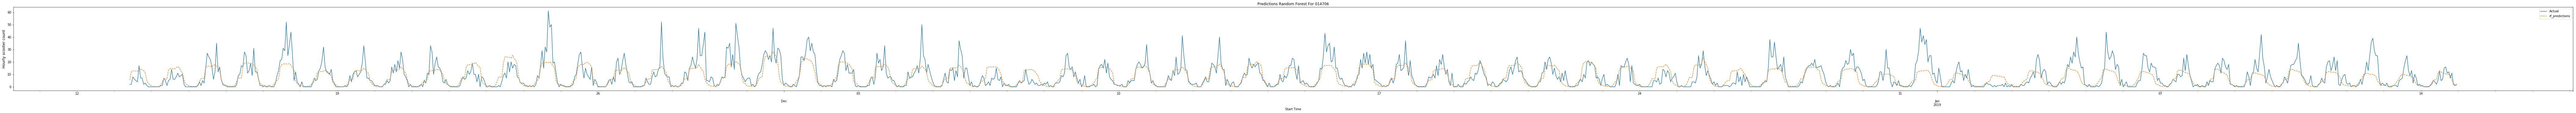

In [15]:
size = int(len(data_cell_data_hour) * 0.66)
train_1, test_1 = data_cell_data_hour[0:size], data_cell_data_hour[size:len(data_cell_data_hour)]
test_results = test_1.drop(['MONTH', 'YEAR', 'HOUR', 'DAY', 'WEEK', 'DAY_OF_WEEK',
       'WEEKEND', 'WEEKDAY',
       'AVG_DAILY_WIND_SPEED', 'PRECIPITATION', 'SNOW', 'AVG_TEMPERATURE', 'HOUR_LABEL',
       'MAX_TEMPERATURE', 'MIN_TEMPERATURE'], axis=1)
test_results.rename(columns=dict(zip(["Trip Counts"], ["Actual"])), inplace=True)
rf_list = best_rf_predictions.tolist()
test_results['rf_predictions'] = rf_list
test_results.plot(style=['-', '--', ':'],figsize=(150, 5))
plt.title('Predictions Random Forest For 014706')
plt.ylabel('Hourly scooter count', fontsize=12)
plt.savefig('../../output/Random_Forest_Predictions_Commuter_Hours_014706_2_greater_than_01.png')

In [20]:
print(test_results['Actual'].median())
print(test_results['rf_predictions'].median())

5.0
5.986026078262272


In [16]:
# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error





# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [ ]:
data_014706_hourly = data_cell_data_hour['Trip Counts']
data = data_014706_hourly.values
data = data.astype('float32')
print(data.shape)
# data split
n_test = 3800
# model configs
cfg_list = sarima_configs()
# grid search
scores = grid_search(data, cfg_list, n_test,parallel=False)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

(4414,)
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 5.001
 > Model[[(0, 0, 0), (0, 0, 1, 0), 'n']] 3.936
 > Model[[(0, 0, 0), (0, 0, 2, 0), 'n']] 3.565
 > Model[[(0, 0, 0), (1, 0, 0, 0), 'n']] 3.176
 > Model[[(0, 0, 0), (1, 0, 1, 0), 'n']] 3.089
 > Model[[(0, 0, 0), (1, 0, 2, 0), 'n']] 3.084
 > Model[[(0, 0, 0), (2, 0, 0, 0), 'n']] 3.088
 > Model[[(0, 0, 0), (2, 0, 1, 0), 'n']] 3.086
 > Model[[(0, 0, 0), (2, 0, 2, 0), 'n']] 3.069
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'c']] 4.130
 > Model[[(0, 0, 0), (0, 0, 1, 0), 'c']] 3.471
 > Model[[(0, 0, 0), (0, 0, 2, 0), 'c']] 3.251
 > Model[[(0, 0, 0), (1, 0, 0, 0), 'c']] 3.081
 > Model[[(0, 0, 0), (1, 0, 1, 0), 'c']] 3.032
 > Model[[(0, 0, 0), (1, 0, 2, 0), 'c']] 3.024
 > Model[[(0, 0, 0), (0, 0, 1, 0), 't']] 3.626
